### Resizing

In [ ]:
import os
import cv2

RAW_DIR = "../data/raw/frames_video"
RESIZE_DIR = "../data/temp/resize"
os.makedirs(RESIZE_DIR, exist_ok=True)

TARGET_SIZE = (640, 640)  # ancho, alto

def resize_image(img_path, target_size):
    img = cv2.imread(img_path)
    return cv2.resize(img, target_size)

for img_name in os.listdir(RAW_DIR):
        img_path = os.path.join(RAW_DIR, img_name)
        resized = resize_image(img_path, TARGET_SIZE)
        cv2.imwrite(os.path.join(RESIZE_DIR, img_name), resized)

### Normalizing

In [7]:
import os
import cv2
import numpy as np

RESIZE_DIR = "../data/temp/resize"
NORMALIZED_DIR = "../data/temp/normalized"
os.makedirs(NORMALIZED_DIR, exist_ok=True)

def normalize_image(img):
    return img.astype(np.float32) / 255.0  # rango 0–1

for img_name in os.listdir(RESIZE_DIR):
    img_path = os.path.join(RESIZE_DIR, img_name)
    img = cv2.imread(img_path)
    normalized = normalize_image(img)
    cv2.imwrite(os.path.join(NORMALIZED_DIR, img_name), (normalized * 255).astype(np.uint8))

### Augmentation

In [8]:
import os
import cv2
import albumentations as A

NORMALIZED_DIR = "../data/temp/normalized"
AUGMENTED_DIR = "../data/temp/augmented"
os.makedirs(AUGMENTED_DIR, exist_ok=True)

transform = A.Compose([
    A.Rotate(limit=20, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, p=0.3)
])

def augment_image(img):
    return transform(image=img)['image']

for img_name in os.listdir(NORMALIZED_DIR):
    img_path = os.path.join(NORMALIZED_DIR, img_name)
    img = cv2.imread(img_path)
    aug_img = augment_image(img)
    cv2.imwrite(os.path.join(AUGMENTED_DIR, f"aug_{img_name}"), aug_img)

### AUGMENTATION (w yolo annotations)

In [18]:
import os
import cv2
import albumentations as A

# Carpetas de entrada y salida
NORMALIZED_IMG_DIR = "../data/temp/normalized/"
YOLO_LABEL_DIR = "../data/raw/annotations_yolo/obj_train_data"
AUGMENTED_IMG_DIR = "../data/temp/augmented/images"
AUGMENTED_LABEL_DIR = "../data/temp/augmented/labels"

os.makedirs(AUGMENTED_IMG_DIR, exist_ok=True)
os.makedirs(AUGMENTED_LABEL_DIR, exist_ok=True)

# Definición de augmentations
transform = A.Compose([
    A.Rotate(limit=20, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit=3, p=0.3),
    A.ColorJitter(brightness=0.2, contrast=0.2, p=0.3)
],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

# Función para leer etiquetas YOLO
def read_yolo_labels(label_path):
    bboxes = []
    labels = []
    with open(label_path, 'r') as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls_id = parts[0]
            coords = list(map(float, parts[1:]))
            bboxes.append(coords)
            labels.append(cls_id)
    return bboxes, labels

# Función para guardar etiquetas YOLO
def save_yolo_labels(label_path, bboxes, labels):
    with open(label_path, 'w') as f:
        for label, box in zip(labels, bboxes):
            f.write(f"{label} {' '.join(map(str, box))}\n")

# Proceso de augmentación
for img_file in os.listdir(NORMALIZED_IMG_DIR):
    if not img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        continue

    img_path = os.path.join(NORMALIZED_IMG_DIR, img_file)
    label_path = os.path.join(YOLO_LABEL_DIR, img_file.rsplit('.', 1)[0] + ".txt")

    if not os.path.exists(label_path):
        print(f"⚠ No label para {img_file}, se omite.")
        continue

    image = cv2.imread(img_path)
    bboxes, labels = read_yolo_labels(label_path)

    if len(bboxes) == 0:
        cv2.imwrite(os.path.join(AUGMENTED_IMG_DIR, img_file), image)
        save_yolo_labels(os.path.join(AUGMENTED_LABEL_DIR, img_file.replace('.jpg', '.txt')), [], [])
        continue

    transformed = transform(image=image, bboxes=bboxes, class_labels=labels)

    # Guardar imagen aumentada
    aug_img_name = f"aug_{img_file}"
    cv2.imwrite(os.path.join(AUGMENTED_IMG_DIR, aug_img_name), transformed['image'])

    # Guardar etiquetas aumentadas
    aug_label_name = aug_img_name.replace('.png', '.txt')
    save_yolo_labels(os.path.join(AUGMENTED_LABEL_DIR, aug_label_name),
                     transformed['bboxes'], transformed['class_labels'])

### Add a seed

In [13]:
import random
import numpy as np

SEED = 42

random.seed(SEED)
np.random.seed(SEED)

# Si usas PyTorch:
# import torch
# torch.manual_seed(SEED)

print(f"Semillas fijadas para reproducibilidad (SEED={SEED})")

Semillas fijadas para reproducibilidad (SEED=42)


### Balanceo de Clases (by instances)

In [19]:
import os
import cv2
import albumentations as A
import random
from collections import Counter
import shutil

# Carpetas
IMG_DIR = "../data/temp/augmented/images"
LABEL_DIR = "../data/temp/augmented/labels"
OUTPUT_IMG_DIR = "../data/temp/balanced/images"
OUTPUT_LABEL_DIR = "../data/temp/balanced/labels"

os.makedirs(OUTPUT_IMG_DIR, exist_ok=True)
os.makedirs(OUTPUT_LABEL_DIR, exist_ok=True)

# Augmentations para oversampling
transform = A.Compose([
    A.RandomBrightnessContrast(p=0.4),
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5)
],
    bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'])
)

# Leer etiquetas YOLO
def read_yolo_labels(label_path):
    bboxes = []
    labels = []
    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            cls_id = parts[0]
            coords = list(map(float, parts[1:]))
            bboxes.append(coords)
            labels.append(cls_id)
    return bboxes, labels

# Guardar etiquetas YOLO
def save_yolo_labels(label_path, bboxes, labels):
    with open(label_path, 'w') as f:
        for label, box in zip(labels, bboxes):
            f.write(f"{label} {' '.join(map(str, box))}\n")

# Contar instancias por clase
class_counts = Counter()
label_files = [f for f in os.listdir(LABEL_DIR) if f.endswith('.txt')]

for lf in label_files:
    _, labels = read_yolo_labels(os.path.join(LABEL_DIR, lf))
    class_counts.update(labels)

print("📊 Distribución inicial de clases:", class_counts)

# Clase con más instancias
max_count = max(class_counts.values())

# Copiar todas las imágenes/labels originales
for img_file in os.listdir(IMG_DIR):
    if img_file.lower().endswith((".jpg", ".png", ".jpeg")):
        shutil.copy(os.path.join(IMG_DIR, img_file), OUTPUT_IMG_DIR)
        label_file = img_file.rsplit('.', 1)[0] + ".txt"
        shutil.copy(os.path.join(LABEL_DIR, label_file), OUTPUT_LABEL_DIR)

# Oversampling para clases minoritarias
for cls_id, count in class_counts.items():
    if count < max_count:
        needed = max_count - count
        print(f"🔄 Balanceando clase {cls_id}: +{needed} instancias")

        # Buscar imágenes que contengan esta clase
        imgs_with_cls = []
        for lf in label_files:
            bboxes, labels = read_yolo_labels(os.path.join(LABEL_DIR, lf))
            if cls_id in labels:
                imgs_with_cls.append(lf.replace('.txt', '.jpg'))

        # Crear imágenes aumentadas hasta completar
        for i in range(needed):
            img_name = random.choice(imgs_with_cls)
            img_path = os.path.join(IMG_DIR, img_name)
            label_path = os.path.join(LABEL_DIR, img_name.replace('.jpg', '.txt'))

            image = cv2.imread(img_path)
            bboxes, labels = read_yolo_labels(label_path)

            transformed = transform(image=image, bboxes=bboxes, class_labels=labels)

            aug_img_name = f"{img_name.rsplit('.', 1)[0]}_bal{i}.jpg"
            cv2.imwrite(os.path.join(OUTPUT_IMG_DIR, aug_img_name), transformed['image'])

            aug_label_name = aug_img_name.replace('.jpg', '.txt')
            save_yolo_labels(os.path.join(OUTPUT_LABEL_DIR, aug_label_name),
                             transformed['bboxes'], transformed['class_labels'])

print("Balanceo completado.")

📊 Distribución inicial de clases: Counter({'0': 167})
Balanceo completado.


Esto significa que todas las anotaciones son de una sola clase (id 0)

## Save Final Dataset 

In [22]:
# save_and_validate_dataset.py
import os
import shutil

# Rutas de entrada y salida
final_images_dir = "../data/temp/balanced/images"   # Carpeta con imágenes ya procesadas
final_labels_dir = "../data/temp//balanced/labels"   # Carpeta con anotaciones YOLO
output_images_dir = "../data/processed/images"
output_labels_dir = "../data/processed/labels"

# Crear carpetas de salida
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_labels_dir, exist_ok=True)

# Función para obtener nombres base sin extensión
def get_file_stems(folder, ext):
    return {os.path.splitext(f)[0] for f in os.listdir(folder) if f.endswith(ext)}

# Validar que cada imagen tenga su etiqueta y viceversa
image_stems = get_file_stems(final_images_dir, ".jpg") | get_file_stems(final_images_dir, ".png")
label_stems = get_file_stems(final_labels_dir, ".txt")

missing_labels = image_stems - label_stems
missing_images = label_stems - image_stems

if missing_labels:
    print(f"⚠️ Imágenes sin etiquetas: {missing_labels}")
if missing_images:
    print(f"⚠️ Etiquetas sin imágenes: {missing_images}")

# Filtrar solo los que están completos
valid_stems = image_stems & label_stems
print(f"✅ Total de pares válidos: {len(valid_stems)}")

# 2️⃣ Guardar solo los archivos válidos
for stem in valid_stems:
    # Copiar imagen
    for ext in [".jpg", ".png"]:
        src_img = os.path.join(final_images_dir, stem + ext)
        if os.path.exists(src_img):
            shutil.copy2(src_img, os.path.join(output_images_dir, stem + ext))
            break
    
    # Copiar etiqueta
    src_label = os.path.join(final_labels_dir, stem + ".txt")
    shutil.copy2(src_label, os.path.join(output_labels_dir, stem + ".txt"))

print(f" Dataset final guardado en {os.path.abspath('data/processed')}")


✅ Total de pares válidos: 7
 Dataset final guardado en /mnt/c/Users/jndrs/Desktop/mquality-cv/notebooks/data/processed


### Clasess Distribution

📊 Distribución antes: Counter({'0': 167})
📊 Distribución después: Counter({'0': 167})


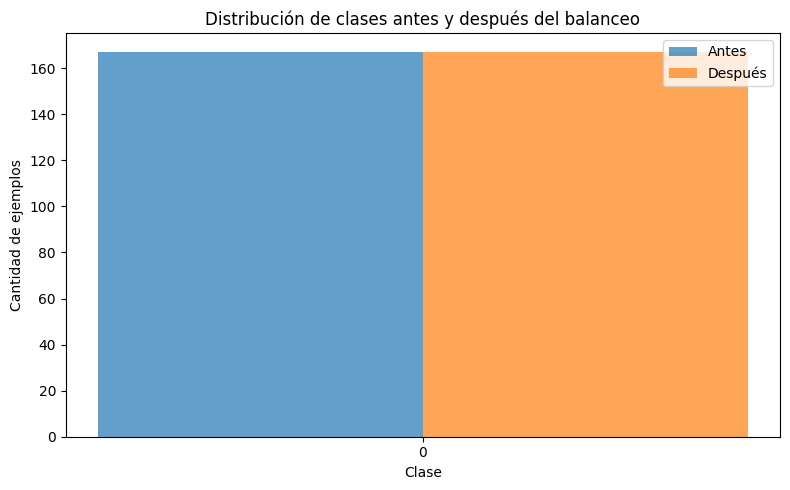

In [23]:
# compare_class_distribution.py
import os
from collections import Counter
import matplotlib.pyplot as plt

# Carpetas antes y después del balanceo
labels_before_dir = "../data/raw/annotations_yolo/obj_train_data"
labels_after_dir = "../data/processed/labels"

def count_classes(labels_dir):
    class_counts = Counter()
    for file in os.listdir(labels_dir):
        if file.endswith(".txt"):
            with open(os.path.join(labels_dir, file), "r") as f:
                for line in f:
                    if line.strip():
                        cls_id = line.split()[0]
                        class_counts[cls_id] += 1
    return class_counts

# 1️⃣ Contar clases
counts_before = count_classes(labels_before_dir)
counts_after = count_classes(labels_after_dir)

print(f"📊 Distribución antes: {counts_before}")
print(f"📊 Distribución después: {counts_after}")

# 2️⃣ Graficar comparación
classes = sorted(set(counts_before.keys()) | set(counts_after.keys()))
before_vals = [counts_before.get(c, 0) for c in classes]
after_vals = [counts_after.get(c, 0) for c in classes]

plt.figure(figsize=(8, 5))
bar_width = 0.35
x = range(len(classes))

plt.bar(x, before_vals, width=bar_width, label="Antes", alpha=0.7)
plt.bar([i + bar_width for i in x], after_vals, width=bar_width, label="Después", alpha=0.7)

plt.xticks([i + bar_width/2 for i in x], classes)
plt.xlabel("Clase")
plt.ylabel("Cantidad de ejemplos")
plt.title("Distribución de clases antes y después del balanceo")
plt.legend()
plt.tight_layout()
plt.show()
